In [1]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
import shutil
import warnings
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision
import sklearn.metrics as metrics
from PIL import Image
import torch.nn.functional as F


criterion = nn.CrossEntropyLoss()

In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [4]:
path0 = '../../dataset/Stanford_chestxray_dataset/'
path = '../../dataset/Stanford_chestxray_dataset/CheXpert-v1.0-small/'
os.listdir(path)

['train.csv', 'train', 'valid.csv', 'valid']

In [5]:
path1 = path + 'train.csv'
df = pd.read_csv(path1)
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
mapping = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Pleural Effusion': 3, 'No Finding': 4, 'Pneumothorax': 5}
disease_labels = {j:i for i,j in mapping.items()}
diseases = ['Consolidation','Cardiomegaly','No Finding','Pleural Effusion','Pneumothorax','Atelectasis']
disease_labels

{0: 'Atelectasis',
 1: 'Cardiomegaly',
 2: 'Consolidation',
 3: 'Pleural Effusion',
 4: 'No Finding',
 5: 'Pneumothorax'}

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
!nvidia-htop.py

Sun Feb 27 13:29:46 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   24C    P8     8W / 250W |   1505MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 21%   55C    

In [9]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
def Evaluate(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []
    with torch.no_grad():
        for i in range(len(df)):
            if df['Frontal/Lateral'][i]=="Lateral":
                continue
            for j in diseases:
                if df[j][i]==1.0:
                    image = pil_loader(path0+df['Path'][i])
                    x = data_transforms['test'](image)
                    x = torch.Tensor(np.expand_dims(x,axis = 0))
                    x = x.to(device)
                    valid_logits = model(x)
                    predict_prob = F.softmax(valid_logits)

                    _,predictions = predict_prob.max(1)
                    predictions = predictions.to('cpu')
                    prediction = int(predictions[0])
                    if df[disease_labels[prediction]][i] and df[disease_labels[prediction]][i]== 1:
                        running_corrects += 1
                    labels.append(mapping[j])
                    predict_prob = predict_prob.to('cpu')

                    pred_labels.extend(list(predictions.numpy()))
                    preds.extend(list(predict_prob.numpy()))
                    total += 1
                    break
            if i==120:
                break
        print('Accuracy:',running_corrects/total)
        return(preds, pred_labels,labels)

def ROC_plot(y_probas,labels):
    for c in range(6):
        fpr = []
        tpr = []
        thresholds = np.arange(0.0, 1.01, .01)

        P = list(labels).count(c)
        N = len(labels) - P

        for thresh in thresholds:
            FP=0
            TP=0
            for i in range(len(labels)):
                if (y_probas[i][c] > thresh):
                    if labels[i] == c:
                        TP = TP + 1
                    else:
                        FP = FP + 1
            fpr.append(FP/float(N))
            tpr.append(TP/float(P))
            
        auc = np.trapz(tpr,fpr)
        plt.plot(fpr, tpr, label = 'Class: {}, auc:{:.2f}'.format(c,auc))
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.show()

# Squeezenet

In [10]:
mobilenet = models.mobilenet_v3_small(pretrained=True)
mobilenet.classifier[3] = nn.Linear(in_features = 1024, out_features = 6, bias = True)
model = mobilenet
model.load_state_dict(torch.load('New/saved5/mobilenetv3.pt'))
model = model.to(device)

In [11]:
preds, pred_labels,labels = Evaluate(model)

Accuracy: 0.4098360655737705


In [12]:
print(metrics.precision_recall_fscore_support(np.array(labels), np.array(pred_labels)))

(array([0.22222222, 0.        , 0.1       , 0.65      , 0.5       ,
       0.05882353]), array([0.33333333, 0.        , 0.25      , 0.5       , 0.16666667,
       0.125     ]), array([0.26666667, 0.        , 0.14285714, 0.56521739, 0.25      ,
       0.08      ]), array([ 6,  5,  4, 26, 12,  8]))


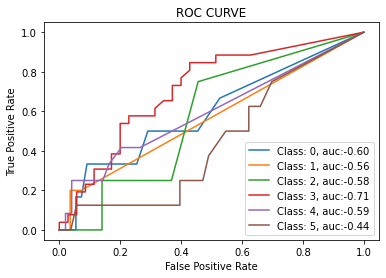

In [15]:
ROC_plot(preds,labels)

In [16]:
print(metrics.classification_report(labels,pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.33      0.27         6
           1       0.00      0.00      0.00         5
           2       0.10      0.25      0.14         4
           3       0.65      0.50      0.57        26
           4       0.50      0.17      0.25        12
           5       0.06      0.12      0.08         8

    accuracy                           0.31        61
   macro avg       0.26      0.23      0.22        61
weighted avg       0.41      0.31      0.34        61

